In [ ]:
# read & manipulate data
import pandas as pd 
import numpy as np
import tensorflow as tf
from collections import Counter
# visualisations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
%matplotlib notebook
#mic
import time

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/cicids2017 dataset/all_data.csv")

#Train/test split

In [ ]:
attack = df[df.anomaly == 1]
normal = df[df.anomaly == 0]
attack = attack.drop('Label', axis=1)
normal = normal.drop('Label', axis=1)
print(f"""Shape of the datasets:
    clean (rows, cols) = {normal.shape}
    fraud (rows, cols) = {attack.shape}""")

Shape of the datasets:
    clean (rows, cols) = (2271320, 80)
    fraud (rows, cols) = (556556, 80)


In [ ]:
# shuffle our training set
normal = normal.sample(frac=1).reset_index(drop=True)

#TRAINING_SAMPLE= math.ceil(normal.shape[0]*(20/100))
TRAINING_SAMPLE = normal.shape[0] - attack.shape[0]

print(f"""training sample size: {TRAINING_SAMPLE} and normal case size: {normal.shape[0]} left out normals: {normal.shape[0]-TRAINING_SAMPLE}""")

# training set: exlusively normal samples
X_train_all = normal.iloc[:TRAINING_SAMPLE]

# testing  set: the remaining normal + all the attack samples 
X_test_normal = normal.iloc[TRAINING_SAMPLE:]
X_test_attack = attack
X_test = normal.iloc[TRAINING_SAMPLE:].append(attack).sample(frac=1)
print(f"""Our testing set is composed as follows:
{X_test.anomaly.value_counts()}""")
print(f"""Class ratio in testing set is composed as follows:
{X_test.anomaly.value_counts(normalize=True)*100}""")

training sample size: 1714764 and normal case size: 2271320 left out normals: 556556
Our testing set is composed as follows:
1    556556
0    556556
Name: anomaly, dtype: int64
Class ratio in testing set is composed as follows:
1    50.0
0    50.0
Name: anomaly, dtype: float64


In [ ]:
print(f"""Shape of the datasets:
    training (rows, cols) = {X_train_all.shape}
    test normal (rows, cols) = {X_test_normal.shape}
    test attack  (rows, cols) = {X_test_attack.shape}""")

Shape of the datasets:
    training (rows, cols) = (1714764, 80)
    test normal (rows, cols) = (556556, 80)
    test attack  (rows, cols) = (556556, 80)


In [ ]:
train_features_set = X_train_all[X_train_all.columns.difference(['anomaly'])].sample(frac=.01, random_state=123)
test_features_benign = X_test_normal[X_test_normal.columns.difference(['anomaly'])].sample(frac=.01, random_state=123)
test_features_malic = X_test_attack[X_test_attack.columns.difference(['anomaly'])].sample(frac=.01, random_state=123)

In [ ]:
print(f"""Shape of the datasets:
    training (rows, cols) = {train_features_set.shape}
    test normal (rows, cols) = {test_features_benign.shape}
    test attack  (rows, cols) = {test_features_malic.shape}""")

Shape of the datasets:
    training (rows, cols) = (17148, 79)
    test normal (rows, cols) = (5566, 79)
    test attack  (rows, cols) = (5566, 79)


#One Class SVM

In [ ]:
from sklearn import svm

In [ ]:
start = time.time()
# fit the model
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma='scale')
clf.fit(train_features_set)
print(time.time() - start)

11.546738862991333


In [ ]:
dataset_name = 'OCSVMcicids2017'

#save the model 

In [ ]:
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
joblib.dump(clf,"/content/drive/MyDrive/cicids2017 dataset/%s.pkl"%dataset_name)

['/content/drive/MyDrive/cicids2017 dataset/OCSVMcicids2017.pkl']

#Loading saved model

In [ ]:
clf = joblib.load("/content/drive/MyDrive/cicids2017 dataset/%s.pkl"%dataset_name)

#Testing

In [ ]:
y_pred_train = clf.predict(train_features_set)
y_pred_test = clf.predict(test_features_benign)
y_pred_outliers = clf.predict(test_features_malic)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

#Results

In [ ]:
y_test_all = np.append(np.ones(len(test_features_benign)),
                   np.ones(len(test_features_malic))*-1)

In [ ]:
y_pred_all = np.append(y_pred_test,y_pred_outliers)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_all,y_pred_all))

              precision    recall  f1-score   support

        -1.0       0.79      0.39      0.52      5566
         1.0       0.60      0.90      0.72      5566

    accuracy                           0.64     11132
   macro avg       0.69      0.64      0.62     11132
weighted avg       0.69      0.64      0.62     11132



#AUC curves

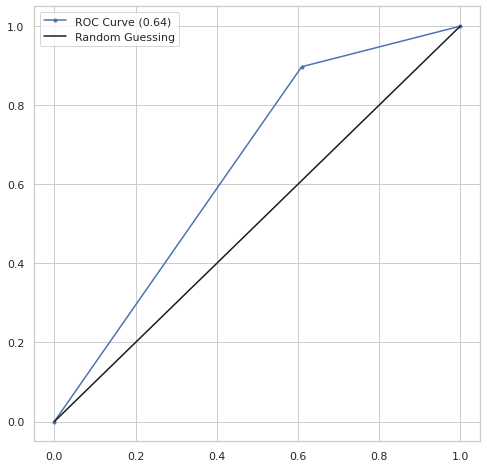

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve


fpr, tpr, thresholds = roc_curve(y_test_all, y_pred_all)
auc_score = roc_auc_score(y_test_all, y_pred_all)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();

#Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
start = time.time()
rng = np.random.RandomState(42)

# fit the model
clf = IsolationForest(behaviour='new', max_samples=1000,
                      random_state=rng, contamination=0.01)
clf.fit(train_features_set)
print(time.time() - start)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:248: FutureWarning: 'behaviour' is deprecated in 0.22 and will be removed in 0.24. You should not pass or set this parameter.
  FutureWarning


1.3968632221221924


In [ ]:
y_pred_train = clf.predict(train_features_set)
y_pred_test = clf.predict(test_features_benign)
y_pred_outliers = clf.predict(test_features_malic)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size

#Results

In [ ]:
y_test_all = np.append(np.ones(len(test_features_benign)),
                   np.ones(len(test_features_malic))*-1)

In [ ]:
y_pred_all = np.append(y_pred_test,y_pred_outliers)

In [ ]:
#from sklearn.metrics import classification_report

print(classification_report(y_test_all,y_pred_all))

              precision    recall  f1-score   support

        -1.0       0.96      0.25      0.40      5566
         1.0       0.57      0.99      0.72      5566

    accuracy                           0.62     11132
   macro avg       0.77      0.62      0.56     11132
weighted avg       0.77      0.62      0.56     11132



#AUC curves

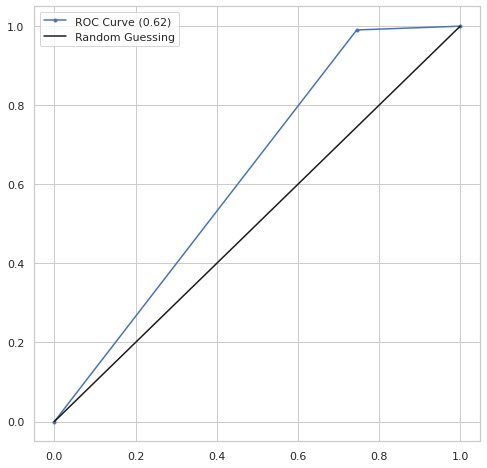

In [ ]:
#from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test_all, y_pred_all)
auc_score = roc_auc_score(y_test_all, y_pred_all)
fig, ax1 = plt.subplots(1, 1, figsize = (8, 8))
ax1.plot(fpr, tpr, 'b.-', label = 'ROC Curve (%2.2f)' %  auc_score)
ax1.plot(fpr, fpr, 'k-', label = 'Random Guessing')
ax1.legend();